# Appendix - LSR - $\sigma\neq0$

In this notebook are gathered all experiments generated for the appendix to illustrate the impact of the step size.

In [5]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt
import pandas as pd

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import KIND_COMPRESSION

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "gamma"

nb_devices_for_the_run = 10
dim_notebook = 20
MAX_NB_DEVICES = 40

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Building data
w_true = generate_param(dim_notebook)
X, Y = build_data_linear(w_true, n_dimensions = dim_notebook, 
                         n_devices=MAX_NB_DEVICES, with_seed=False, without_noise=False)
pickle_saver((X, Y), filename + "-data")

Text(0.5, 1.0, 'Model weights')

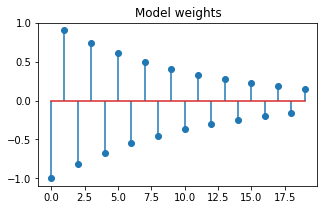

In [3]:
plt.figure(figsize=(5, 3))
plt.stem(w_true, use_line_collection=True)
plt.title("Model weights")

In [6]:
obj_min_by_N = {}
for nb_devices in tqdm(DEVICE_RANGE):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=600, 
                                                     quantization_param=0, 
                                                     momentum = 0., 
                                                     verbose=False, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

 17%|█▋        | 1/6 [00:00<00:00,  6.00it/s]

Large dimension...
Large dimension...


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


In [7]:
%%time
all_kind_of_compression_res = []
all_legends = []
for type_params in tqdm(KIND_COMPRESSION):
    all_devices_res = []
    for nb_devices in DEVICE_RANGE:
        myX = X[:nb_devices]
        myY = Y[:nb_devices]
        all_descent = {}
        for i in range(len(step_formula)):
            multiple_sg_descent = multiple_run_descent(type_params, myX, myY, step_formula=step_formula[i], nb_epoch=10)
            all_descent[step_formula_labels[i]] = multiple_sg_descent
        all_devices_res.append(ResultsOfSeveralDescents(all_descent, nb_devices))
        all_legends.append("$N = " + str(nb_devices) + "$")
    all_kind_of_compression_res.append(all_devices_res)
            
pickle_saver(all_legends, filename + "-legends")
pickle_saver(all_kind_of_compression_res, filename + "-alldescent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large dimension...
Large dimension...
Large dimension...
Large dimension...
Large dimension...
SGD
Large 

  0%|          | 0/5 [00:49<?, ?it/s]


KeyboardInterrupt: 

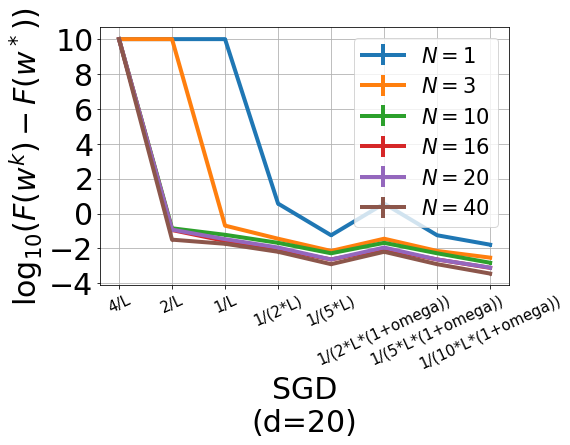

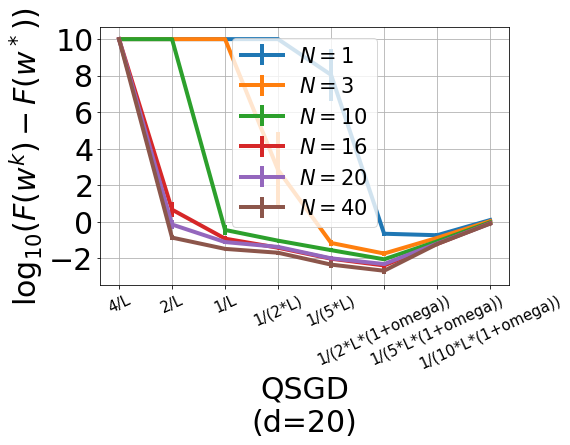

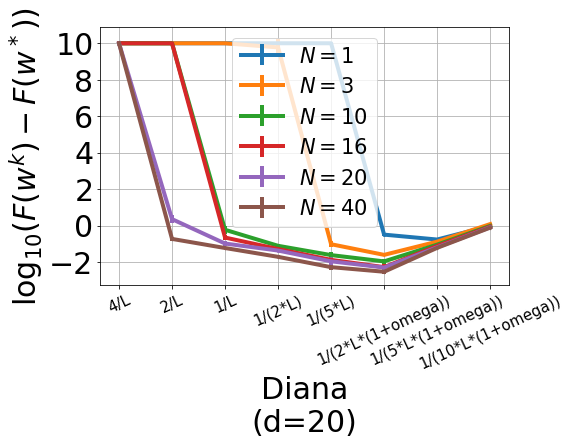

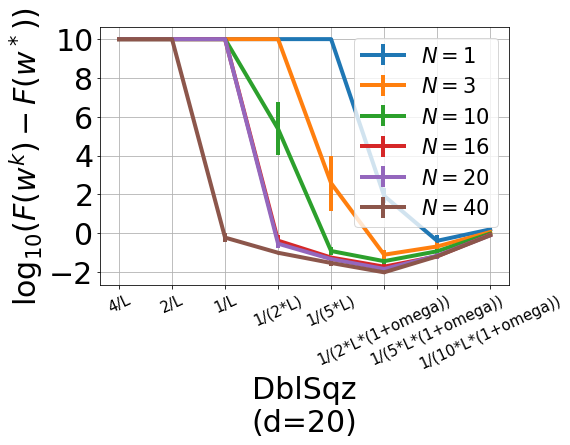

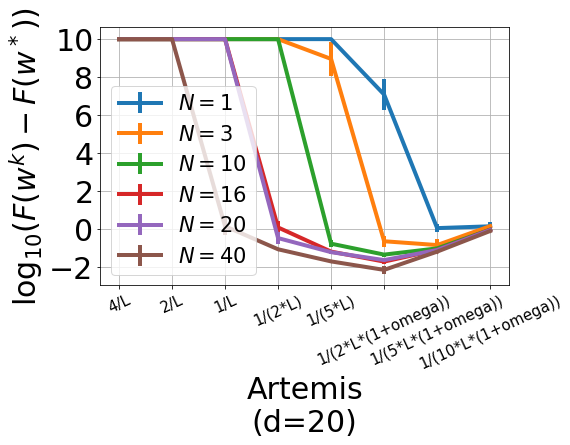

In [6]:
#(X,Y) = pickle_loader(filename + "-data")
obj_min_by_N = pickle_loader(filename + "-obj_min")
all_kind_of_compression_res = pickle_loader(filename + "-alldescent")
all_legends = pickle_loader(filename + "-legends")

#fig, axes = plt.subplots(figsize=(15,12))
#for i, sub in zip(range(4),[221, 222, 223, 224]):
for i in range(5):
    plot_multiple_run_each_curve_different_objectives(
        range(1,len(step_formula)+1), 
        all_kind_of_compression_res[i], 
        dim_notebook,
        all_legends, obj_min_by_N,
        DEVICE_RANGE, step_formula_labels,
        KIND_COMPRESSION[i].name(),
        subplot=None
    ) 
plt.show()